# Управление компонентами мобильных платформ

## Описание

Используется модель *BipedalWalker-v3* из *Gymnasium Documentation*. Она представляет собой среду с 24 характеристиками состояний и 4 возможными действиями:
- сустав левого бедра: значение [-1,1] (вращение вперед/назад);
- сустав левого колена: значение [-1,1] (сгибание/разгибание);
- сутав правого бедра: значение [-1,1] (вращение вперед/назад);
- сустав правого колена: значение [-1,1] (сгибание/разгибание).

Под значениями имеется скорость двигателя сустава. Для характеристик состояний в документации дано следующее описание (с англ.):

*Состояние включает в себя углол наклона корпуса, угловую скорость копруса, горизонтальную скорость корпуса, вертикальную скорость корпуса, положение сочленений и угловую скорость сочленений, контакт стоп с землёй и 10 измерений лидара-дальномера (дистанция до земли).*

Более подробно: https://gymnasium.farama.org/environments/box2d/bipedal_walker/

**Данная имитационная среда была выбрана именно потому, что устройство и доступное время не позволяет обучать агента в более сложных средах.**

Под более сложными средами имеется в виду большее количество характеристик состояний и вариативность действий.

*Замечание:*
Обучение не завершилось до конца с абсолютным успехом, но наблюдается тенденция к осознанию агентом окружающей среды. Для достижения лучшего результата можно поменять гиперпараметры и константные настройки (30000 эпизодов, например). Отсутствие ядер 'cuda' делает этот процесс "мучительным".
Поэтому данное задание выполнено как наиболее успешная попытка.

## Листинг

Импортирование необходимых библиотек

In [1]:
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io
import numpy as np
import os
from collections import deque
# Для визуализации
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML
from IPython import display
import glob

Инициализация имитационной среды *BipedalWalker-v3* без хардкор режима

In [2]:
# Инициализация среды и переменных
env = gym.make('BipedalWalker-v3', render_mode='rgb_array')
obs, info = env.reset(seed=0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Вывод
print(f'State shape: {env.observation_space.shape}\tState dimension: {state_dim}')
print(f'Action shape: {env.action_space.shape}\tAction dimension: {action_dim}')
print('DEVICE: ', device)

State shape: (24,)	State dimension: 24
Action shape: (4,)	Action dimension: 4
DEVICE:  cpu


Гиперпараметры и константные настройки

In [3]:
# Гиперпараметры
## Актор-сеть и Критик-сеть
LR_ACTOR = 1e-4       # Скорость обучения Актор-сети
LR_CRITIC = 1e-4      # Скорость обучения Критик-сети
MAX_GRAD_NORM = 0.5   # Максимальная норма градиентов (для gradien clipping) для стабилизации
ENTROPY_WEIGTH = 0.01 # Вес энтропийного бонуса для разнообразия распределения выбора действий
CLIP_VAL = 0.2        # Параметр ε для PPO-клипа (обрезания границ при обновлении политики)
# Константные настройки
MAX_STEPS =2048       # Количество шагов в одном эпизоде (rollout)
SAMPLE_N_EPOCH=4      # Количество проходов по эпизоду (rollout) для обучения
SAMPLE_MB_SIZE=64     # Размер мини-батча в эпизоде (rollout)
MAX_EPISODE=20000     # Количество эпизодов (rollout-ов)
TARGET_SCORE=300      # Целевая награда для прохождения (для BipedalWalker-v3)
TARGET_MAX_STEP=1600  # Число шагов в эпизоде для успешного завершения среды (для BipedalWalker-v3)
## Дисконтированное суммарное вознаграждение и GAE
GAMMA = 0.99          # Коэффициент дисконтирования
LAMBDA = 0.95         # Коэффициент сглаживания

Модуль для добавления смещения (в нашем случае - для параметризации логарифма стандартного отклонения в стохастическом распределении)

In [4]:
# Модуль AddBias
class AddBias(nn.Module):
    def __init__(self, bias):
        super(AddBias, self).__init__()
        self._bias = nn.Parameter(bias.unsqueeze(1)) # Обучаемое смещение; размерность: (N,1)
    
    def forward(self, x):
        bias = self._bias.t().view(1, -1) # Для удобства: (N,1) -> (1,N)
        return x + bias

Модуль для упрощенного вычисления логарифмов плотности вероятностей выбранных действий, энтропии и среднего значения

In [5]:
# Модуль FixedNormal
class FixedNormal(torch.distributions.Normal):
    """ Расширяет стандартный класс нормального распределения PyTorch: mean=0, std=1 """
    def log_probs(self, x):
        # Складывает логарифмы плотностей вероятностей для всех размерностей (здесь: действий)
        return super().log_prob(x).sum(-1)
    
    def entropy(self):
        # Складывает энтропии действий (энтропия - мера неопределенности распределения) 
        return super().entropy().sum(-1)

    def mode(self):
        # Возвращает среднее значение для детерминированного выбора действия 
        return self.mean

Модуль для создания нормального распределения с диагональной ковариацией (вероятностная политика агента в непрерывном пространстве действий)

In [6]:
# Модуль DiagGaussian
class DiagGaussian(nn.Module):
    def __init__(self, inp_dim, out_dim):
        super(DiagGaussian, self).__init__()
        # mean = W * x + b, где W - матрица весов, x - входные признаки, b - смещение.
        self.fc_mean = nn.Linear(inp_dim, out_dim)
        #  Изначально std=exp(0)=1. Однако, фиксирование стандартного отклонения на одном значении приводит к тому,
        # что агент имеет необучаемое распределение действий в среде.
        # Поэтому добавление обучаемого смещения к logstd позволяет иметь независимые параметры для каждого измерения действия.
        self.b_logstd = AddBias(torch.zeros(out_dim))
    
    def forward(self, x):
        mean = self.fc_mean(x)
        logstd = self.b_logstd(torch.zeros_like(mean))
        # Для каждого измерения i: X_i ~ Normal(mean_i, std_i), где std_i = exp(logstd_i)
        return FixedNormal(mean, logstd.exp())

Создание Актор-сети для обучения корректированию политики агента

In [7]:
# Модуль Actor-сети
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, seed):
        """ Класс Actor — реализует актор-сеть (политику) для RL агента.
            Получает состояние среды на входе и выдает распределение действий.
            Политика параметризована диагональным гауссовским распределением.
            
        Параметры:
        ==========
            state_dim (int): размерность входного состояния
            action_dim (int): размерность действия
            seed (int): зерно случайности, 0 - означает отсуствие случайности.
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.dist = DiagGaussian(128, action_dim)
        
    def forward(self, state, deterministic=False):
        """ Прямой проход: возвращает выбранное действие 
            (с наибольшей вероятностью или случайное) 
            и логарифм вероятности выбора действия (для обучения)
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        dist = self.dist(x) # Получаем распределение

        if deterministic:
            action = dist.mode() # Для тестирования
        else:
            action = dist.sample() # Сэмплирование из распределения

        return action, dist.log_probs(action)

    def choose_action(self, state, deterministic=False):
        """ Аналогично forward для отладки без обучения """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        dist = self.dist(x)

        if deterministic:
            return dist.mode()

        return dist.sample()

    def evaluate(self, state, action):
        """ Для оценки текущей политики за счет
            логарифма вероятности и энтропии
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        dist = self.dist(x)

        return dist.log_probs(action), dist.entropy()

Создание Критик-сети для оценки действий агента

In [8]:
# Модуль Критик-сети
class Critic(nn.Module):
    def __init__(self, state_dim, seed):
        """ Класс Critic — реализует критик-сеть (действий) для RL агента.
            Получает состояние среды на входе и предсказывает суммарную ожидаемую награду.
            Оценивает значение состояния V(s).
            
        Параметры:
        ==========
            state_dim (int): размерность входного состояния
            seed (int): зерно случайности, 0 - означает отсуствие случайности.
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state):
        """ Прямой проход: возвращает оценки значений состояний """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x).squeeze(-1) # Для удобства: (batch_size,)

Вывод структур и параметров Актор и Критик сетей (для понимания)

In [9]:
actor_net = Actor(state_dim, action_dim, seed=0)
critic_net = Critic(state_dim, seed=0)
print(f"Структура и параметры Актор-сети\n{actor_net}\n")
print(f"Структура и параметры Критик-сети\n{critic_net}")

Структура и параметры Актор-сети
Actor(
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (dist): DiagGaussian(
    (fc_mean): Linear(in_features=128, out_features=4, bias=True)
    (b_logstd): AddBias()
  )
)

Структура и параметры Критик-сети
Critic(
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)


Модуль, собирающий батч опыта (rollout) в среде. Можно сказать, что rollout является аналогом повторяемой памяти ReplayBuffer в алгоритме DQN

In [10]:
# Модуль EnvRunner
class EnvRunner:
    def __init__(self, state_dim, action_dim):
        """ Объект класса EnvRunner.
        
        Параметры:
        ==========
            state_dim (int): количетсво характеристик состояний среды
            action_dim (int): вариативность действий в среде
        """
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = GAMMA
        self.lamb = LAMBDA
        self.max_steps = MAX_STEPS
        self.device = device

        # Хранение данных, полученных за rollout
        # mb - mini-batch
        """ mb_states: состояния
            mb_actions: действия
            mb_values: оценка ценности состояний
            mb_rewards: награды
            mb_action_logprobs: логарифмы вероятностей выбранных действий
        """
        self.mb_states = np.zeros((self.max_steps, self.state_dim), dtype=np.float32)
        self.mb_actions = np.zeros((self.max_steps, self.action_dim), dtype=np.float32)
        self.mb_values = np.zeros((self.max_steps,), dtype=np.float32)
        self.mb_rewards = np.zeros((self.max_steps,), dtype=np.float32)
        self.mb_action_logprobs = np.zeros((self.max_steps,), dtype=np.float32)
    
    # Ниже реализованы две функции для вычисления оценки действия в конкретном состоянии среды
    # Дисконтированное суммарное вознаграждение
    def compute_discounted_return(self, rewards, last_value):
        """ Вычисляет дисконтированное суммарное вознаграждение (return):
            R_t = r_t + γ * r_{t+1} + γ^2 * r_{t+2} + ... + γ^n * V(s_{t+n})
        """
        returns = np.zeros_like(rewards)
        n_step = len(rewards)
        for t in reversed(range(n_step)):
            if t == n_step - 1:
                returns[t] = rewards[t] + self.gamma * last_value
            else:
                returns[t] = rewards[t] + self.gamma * returns[t+1]
        return returns
        
    # Обобщенная оценка преимущества (GAE)
    def compute_gae(self, rewards, values, last_value):
        """ Вычисляет обобщённую оценку преимущества (GAE).
            GAE помогает снизить дисперсию оценки A[t] = Q(s[t],a[t]) - V(s[t]), 
            обеспечивая более стабильное обучение в ряде случаев.
        """
        advantages = np.zeros_like(rewards)
        n_step = len(rewards)
        last_gae = 0.0
        for t in reversed(range(n_step)):
            # Получаем V(s[t+1])
            if t == n_step - 1:
                next_value = last_value # bootstrap
            else:
                next_value = values[t+1]
            # Дельта-термин TD - это ошибка на шаге t
            # Коэффициент дисконтирования γ учитывает будущее
            # Коэффициент сглаживания λ снижает дисперсию
            # Дельта-термин: TD[t] = r[t] + γ * V(s[t+1]) - V(s[t])
            delta = rewards[t] + self.gamma*next_value - values[t]
            # Рекурсивное вычисление GAE: A[t] = TD[t] + γλTD[t+1] + γ^2 * λ^2 * TD[t+2] + ...
            advantages[t] = last_gae = delta + self.gamma*self.lamb*last_gae
        # GAE = Advantages + Values
        return advantages + values

    def run(self, env, actor_net, critic_net):
        """ Один rollout (эпизод) взаимодействия с окружающей средой:
            собирает состояния, действия, значения, лог-вероятности и награды.
        """
        # 1. Сброс среды
        state, _ = env.reset()
        episode_len = self.max_steps
        
        for step in range(self.max_steps):
            # state(state_dim) -> state(1, state_dim) для подачи в Актор-сеть
            state_tensor = torch.tensor(np.expand_dims(state, axis=0), dtype=torch.float32, device=self.device)
            
            # 2. Через Актор-сеть получаем действие и логарифм вероятности действия
            action, action_logprob = actor_net(state_tensor)
            # 3. Через Критик-сеть оцениваем ценность этого состояния
            value = critic_net(state_tensor)

            # 4. Сохраняем данные rollout
            # Переносим необходимые данные с cuda на cpu (при необходимости, иначе не будет доступа к ним)
            action = action.cpu().numpy()[0]
            action_logprob = action_logprob.cpu().numpy()
            value  = value.cpu().numpy()
            # Сохраняем данные
            self.mb_states[step] = state
            self.mb_actions[step] = action
            self.mb_action_logprobs[step] = action_logprob.item()
            self.mb_values[step] = value.item()
            
            # 5. Шаг среды и сохранение награды в rollout buffer
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            # Сохраняем данные
            self.mb_rewards[step] = reward
            
            if done:
                episode_len = step + 1
                break
        
        # 6. Получаем оценку ценности состояния для bootstrap в GAE
        last_value = critic_net(torch.tensor(np.expand_dims(state, axis=0), dtype=torch.float32, device=self.device)).cpu().numpy().item()

        # 7. Вычисляем returns (таргеты для Критик-сети): дисконтированная сумма или GAE.
        mb_returns = self.compute_discounted_return(self.mb_rewards[:episode_len], last_value)
        #mb_returns = self.compute_gae(self.mb_rewards[:episode_len], self.mb_values[:episode_len], last_value)

        # Возвращаем полученные данные
        return ( self.mb_states[:episode_len],
                 self.mb_actions[:episode_len],
                 self.mb_action_logprobs[:episode_len],
                 self.mb_values[:episode_len],
                 mb_returns,
                 self.mb_rewards[:episode_len])

Модуль, реализующий класс обучения агента в среде с использованием алгоритма Proximal Policy Optimization (PPO)

In [11]:
# Модуль PPOAgent
class PPOAgent:
    def __init__(self, actor_net, critic_net):
        """ Объект класса PPOAgent.
        
        Параметры:
        ==========
            actor_net (nn.Module) : Актор-сеть параметризации политики (π), выбирающая действия в зависимости от текущего состояния
            critic_net (nn.Module): Критик-сеть ценности состояний (V), оценивающая ценность состояния
        """
        self.actor_net = actor_net.to(device)
        self.critic_net = critic_net.to(device)

        self.max_grad_norm = MAX_GRAD_NORM
        self.entropy_weight = ENTROPY_WEIGTH
        self.clip_val = CLIP_VAL
        self.sample_n_epoch = SAMPLE_N_EPOCH
        self.sample_mb_size = SAMPLE_MB_SIZE

        self.optimizer_actor = torch.optim.Adam(self.actor_net.parameters(), lr=LR_ACTOR)
        self.optimizer_critic = torch.optim.Adam(self.critic_net.parameters(), lr=LR_CRITIC)

    def train(self, mb_states, mb_actions, mb_old_values, mb_advantages, mb_returns, mb_old_action_logprobs):
        """ Обучает агента в среде по данным rollout за счет сетей Actor и Critic 
        
        Параметры:
        ==========
            mb_states	           : состояния среды за эпизод
            mb_actions	           : действия, выбранные агентом
            mb_old_values          : значения V(s) до обновления политики
            mb_advantages          : преимущества (advantage estimates)
            mb_returns	           : возвраты (targets для критика)
            mb_old_action_logprobs : логарифмы вероятностей действий по старой политике
        """ 
        # Переводим в тензоры для применения Актор-сети и Критик-сети
        mb_states = torch.from_numpy(mb_states).float().to(device)
        mb_actions = torch.from_numpy(mb_actions).float().to(device)
        mb_old_values = torch.from_numpy(mb_old_values).float().to(device)
        mb_advantages = torch.from_numpy(mb_advantages).float().to(device)
        mb_returns = torch.from_numpy(mb_returns).float().to(device)
        mb_old_action_logprobs = torch.from_numpy(mb_old_action_logprobs).float().to(device)

        # Разбиваем накопленный опыт эпизода (rollout) на мини-батчи для обучения
        episode_len = len(mb_states)
        rand_idx = np.arange(episode_len)
        sample_n_mb = episode_len // self.sample_mb_size

        # Если мини-батчей не хватает из-за длины эпизода и их желаемого количества
        if sample_n_mb <= 0: # То весь эпизод берем за мини-батч
            sample_mb_size = episode_len
            sample_n_mb = 1
        else: # Иначе оставляем
            sample_mb_size = self.sample_mb_size

        # Запускаем цикл обучения
        for _ in range(self.sample_n_epoch):
            np.random.shuffle(rand_idx) # Перемешиваем мини-батчи
            for j in range(sample_n_mb):
                idx = rand_idx[j * sample_mb_size: (j + 1) * sample_mb_size]

                # 1. Собираем данные мини-батча
                states = mb_states[idx]
                actions = mb_actions[idx]
                old_values = mb_old_values[idx]
                old_logprobs = mb_old_action_logprobs[idx]
                advantages = mb_advantages[idx]
                returns = mb_returns[idx]

                # 2. Вычисляем значения по новой политике
                new_logprobs, entropy = self.actor_net.evaluate(states, actions)
                values = self.critic_net(states)
                entropy = entropy.mean()

                # 3. Вычисляем ошибку Критик-сети (Value Network)
                v_pred_clip = old_values + torch.clamp(values - old_values, -self.clip_val, self.clip_val)
                v_loss1 = (returns - values).pow(2) # MSE между returns и новыми values без обрезания
                v_loss2 = (returns - v_pred_clip).pow(2) # MSE returns и новыми values с обрезанием
                value_loss = torch.max(v_loss1, v_loss2).mean()

                # 4. Вычисляем ошибки Актор-сети (Policy Network)
                ratio = (new_logprobs - old_logprobs).exp()
                pg_loss1 = -advantages * ratio
                pg_loss2 = -advantages * torch.clamp(ratio, 1.0 - self.clip_val, 1.0 + self.clip_val)
                policy_loss = torch.max(pg_loss1, pg_loss2).mean() - self.entropy_weight * entropy

                # Обновляем Актор-сеть
                self.optimizer_actor.zero_grad()
                policy_loss.backward()
                nn.utils.clip_grad_norm_(self.actor_net.parameters(), self.max_grad_norm)
                self.optimizer_actor.step()

                # Обновляем Критик-сеть
                self.optimizer_critic.zero_grad()
                value_loss.backward()
                nn.utils.clip_grad_norm_(self.critic_net.parameters(), self.max_grad_norm)
                self.optimizer_critic.step()

        return policy_loss.item(), value_loss.item(), entropy.item()

Реализуем функцию, которая запускает один эпизод обученной модели для тестирования и сохраняет видео теста

In [12]:
def play(actor_net, env_name='BipedalWalker-v3', video_path="video", filename="rl-video"):
    """ Запускает среду, проигрывает эпизод с актор-сетью actor_net,
        записывает видео с префиксом filename в папку video_path.
    """
    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(env, video_folder=video_path, name_prefix=filename, episode_trigger=lambda x: True)

    obs, _ = env.reset()
    total_reward = 0
    step_count = 0
    done = False

    with torch.no_grad():
        while not done:
            state_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            action = actor_net.choose_action(state_tensor, deterministic=True)
            action = action.cpu().numpy()[0]

            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            total_reward += reward
            step_count += 1

    env.close()
    print(f"[Evaluation] Total reward = {total_reward:.2f}, steps = {step_count}")

Реализуем функцию нахождения последнего сохраненного видео

In [13]:
def find_latest_video(video_folder, prefix):
    """ Ищет последний по времени создания видеофайл с заданным префиксом в папке video_folder.
        Возвращает полный путь к файлу или None, если файлов нет.
    """
    pattern = os.path.join(video_folder, prefix + '*.mp4')
    files = glob.glob(pattern)
    if not files:
        return None
    latest_file = max(files, key=os.path.getmtime)
    return latest_file

Реализуем функцию для вывода видео в Jupyter notebook

In [14]:
def show_video(video_path):
    """ Показывает видео в Jupyter Notebook из файла по пути video_path.
        Если файл не найден, выводит сообщение.
    """
    if video_path is None:
        print("Could not find video")
        return
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    display.display(HTML(data=f'''
        <video alt="video" autoplay loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
        </video>
    '''))

Реализуем функцию для запуска алгоритма Proximal Policy Optimization (PPO)

In [15]:
def ppo(env, runner, actor_net, critic_net, agent, save_path="model.pt"):
    """ Запускает алгоритм PPO.

    Парамтеры:
    ==========
        env : среда Gym (например, BipedalWalker-v3)
        runner : объект для запуска эпизодов и сбора данных
        actor_net : Актор-сеть
        critic_net : Критик-сеть
        agent : PPO агент — реализует обучение на основе собранных данных
    """
    scores_window = deque(maxlen=100)
    scores = []
    mean_total_reward = 0
    mean_length = 0

    for i in range(1, MAX_EPISODE + 1):
        # Собираем опыт
        with torch.no_grad():
            mb_states, mb_actions, mb_old_action_logpobs, mb_values, mb_returns, mb_rewards = runner.run(env, actor_net, critic_net)
            mb_advantages = mb_returns - mb_values
            # Нормализация преимуществ (advantages) для стабильности
            mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-6)

        # Обучаем агента
        pg_loss, v_loss, ent = agent.train(mb_states, mb_actions, mb_values, mb_advantages, mb_returns, mb_old_action_logpobs)
        episode_reward = mb_rewards.sum()
        episode_len = len(mb_states)
        # Запись полученных наград для вывода
        scores.append(episode_reward)
        scores_window.append(episode_reward)
        mean_total_reward += episode_reward
        mean_length += episode_len
        
        # Периодическое сохранение модели и вывод видео
        if i % 100 == 0 and i > 0:
            print(f"\n[{i:5d} / {MAX_EPISODE:5d}]")
            print("----------------------------------")
            print(f"actor loss = {pg_loss:.6f}")
            print(f"critic loss = {v_loss:.6f}")
            print(f"entropy = {ent:.6f}")
            print(f"mean return = {mean_total_reward / 100:.6f}")
            print(f"mean length = {mean_length / 100:.2f}")
            print("\nSaving the model ... ", end="")

            try:
                torch.save({
                    "it": i,
                    "ActorNet": actor_net.state_dict(),
                    "CriticNet": critic_net.state_dict()
                }, save_path)
                print("Done.\n")
            except Exception as e:
                print(f"Failed to save model: {e}\n")

            # Текущее обучение агента, видео и название
            #prefix = f"ppo-step-{i}"
            #play(actor_net, filename=prefix)
            #latest_video = find_latest_video("video", prefix)
            #show_video(latest_video)

            mean_total_reward = 0
            mean_length = 0
        
            # Проверка условия решения задачи
            avg_score = np.mean(scores_window)
            if avg_score >= TARGET_SCORE and episode_len <= TARGET_MAX_STEP:
                print(f"\nEnvironment solved in {i} episodes! Average Score: {avg_score:.2f}")
                torch.save(actor_net.state_dict(), "ppo_actor.pth")
                torch.save(critic_net.state_dict(), "ppo_critic.pth")
                print("Final model saved.")
                play(actor_net, filename="ppo-success")
                show_video("BipedalWalker-v3")
                break

    return scores

Инициализация и работа программы

In [16]:
runner = EnvRunner(state_dim, action_dim)

In [17]:
agent = PPOAgent(actor_net, critic_net)
scores = ppo(env, runner, actor_net, critic_net, agent)


[  100 / 20000]
----------------------------------
actor loss = -0.011451
critic loss = 2.940647
entropy = 5.660858
mean return = -107.895828
mean length = 505.28

Saving the model ... Done.


[  200 / 20000]
----------------------------------
actor loss = -0.202031
critic loss = 1478.397705
entropy = 5.737325
mean return = -118.437401
mean length = 699.39

Saving the model ... Done.


[  300 / 20000]
----------------------------------
actor loss = 0.045532
critic loss = 4623.353516
entropy = 5.775700
mean return = -102.669128
mean length = 411.49

Saving the model ... Done.


[  400 / 20000]
----------------------------------
actor loss = -0.040099
critic loss = 6196.628906
entropy = 5.818921
mean return = -101.937195
mean length = 380.45

Saving the model ... Done.


[  500 / 20000]
----------------------------------
actor loss = -0.147473
critic loss = 2342.769531
entropy = 6.000100
mean return = -101.405632
mean length = 1041.22

Saving the model ... Done.


[  600 / 20000]
------

График обучения агента

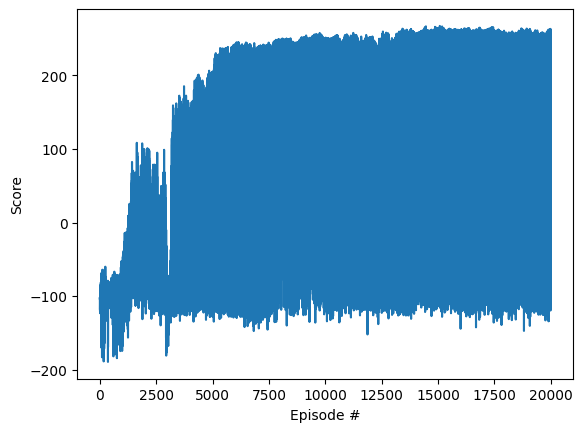

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Загрузка сохраненного чекпоинта с последнего обучения

In [19]:
# Загрузка модели
checkpoint = torch.load("model.pt", map_location=torch.device("cpu"))
actor_net.load_state_dict(checkpoint["ActorNet"])
critic_net.load_state_dict(checkpoint["CriticNet"])
it = checkpoint.get("it", "неизвестно")
print("Модель загружена с эпизода:", it)

Модель загружена с эпизода: 20000


Создание видео результата

In [20]:
play(actor_net, filename=f"ppo-step-{it}")

[Evaluation] Total reward = 265.21, steps = 868


Отображение результата

In [21]:
latest_video = find_latest_video("video", f"ppo-step-{it}")
show_video(latest_video)